In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



In [69]:
seed=42

In [70]:
infile = './processed/CLARITY_Export_2021-01-28_222148_processed_stats_normalized.csv'
df = pd.read_csv(infile)
df.head()

,Min,Max,Diff Glucose,Diff Time,Low
0,0.314540,0.317507,0.002967,5.0,0
1,0.186944,0.317507,-0.127596,19.0,0
2,0.166172,0.317507,-0.148368,25.0,0
3,0.130564,0.317507,-0.183976,29.0,0
4,0.130564,0.317507,-0.053412,29.0,0


In [71]:
df['Low'].value_counts()

0    17048
1     1292
Name: Low, dtype: int64

Classes imablanced (17000+ 0 / Not Low vs 1300 1 / Low), so try SMOTE Over and Undersampling

In [72]:
train, test = train_test_split(df, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

In [73]:
sm = SMOTE(random_state=seed)

res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set

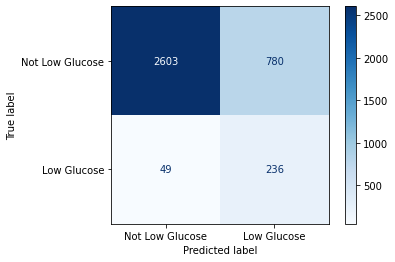

In [78]:
model = LogisticRegression().fit(res_x, res_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


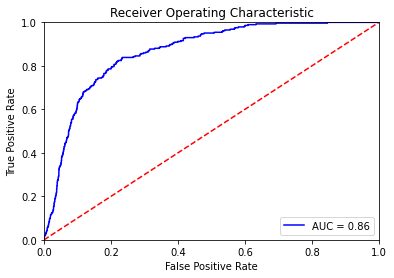

In [79]:
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

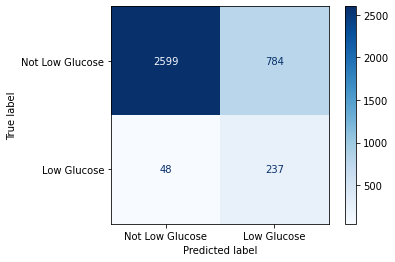

In [80]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(res_x, res_y)

disp = plot_confusion_matrix(clf, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


Undersample the majority class

In [93]:
low = df[df['Low'] == 1.0]
not_low = df[df['Low'] == 0.0].sample(n = 1292, random_state=seed)

df_us = low.append(not_low)

In [94]:
### Train on undersampled set
train, test = train_test_split(df_us, test_size=0.2, random_state=seed)
train_x = train.iloc[:,0:-1]
train_y = train.iloc[:,-1]

test_x = test.iloc[:,0:-1]
test_y = test.iloc[:,-1]


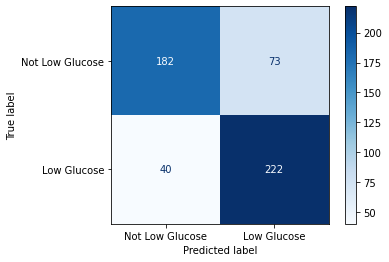

In [95]:
model = LogisticRegression().fit(train_x, train_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


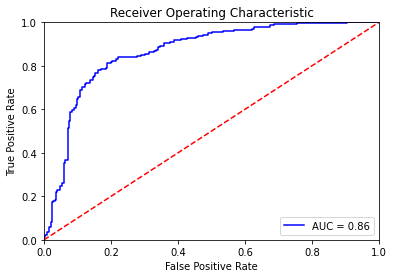

In [98]:
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()